In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve, train_test_split, KFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import StandardScaler,RobustScaler,MinMaxScaler
from sklearn.preprocessing import PowerTransformer,LabelEncoder,OrdinalEncoder
from sklearn.impute import KNNImputer , SimpleImputer       #-----------------------------------  only for numerical data

In [54]:
df=pd.read_csv('Expense.csv')
df.head()

,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,Expense
0,39,Self-emp-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,15024,0,50,United-States,>50K
1,20,Private,Some-college,10,Never-married,Other-service,Own-child,White,Male,0,0,40,United-States,<=50K
2,50,Private,Doctorate,16,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,1902,65,United-States,>50K
3,38,State-gov,HS-grad,9,Married-civ-spouse,Prof-specialty,Wife,White,Female,0,0,40,United-States,>50K
4,23,Local-gov,Bachelors,13,Never-married,Prof-specialty,Own-child,White,Female,0,0,60,United-States,<=50K


In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             5000 non-null   int64 
 1   workclass       5000 non-null   object
 2   education       5000 non-null   object
 3   education-num   5000 non-null   int64 
 4   marital-status  5000 non-null   object
 5   occupation      5000 non-null   object
 6   relationship    5000 non-null   object
 7   race            5000 non-null   object
 8   sex             5000 non-null   object
 9   capital-gain    5000 non-null   int64 
 10  capital-loss    5000 non-null   int64 
 11  hours-per-week  5000 non-null   int64 
 12  native-country  5000 non-null   object
 13  Expense         5000 non-null   object
dtypes: int64(5), object(9)
memory usage: 547.0+ KB


**Observations**
* there are 14 columns and 5000 rows 
* categorical column is 9 

In [56]:
df.describe()

,age,education-num,capital-gain,capital-loss,hours-per-week
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,38.656000,10.065000,1104.080000,90.032800,40.566200
std,13.698292,2.558141,7579.674371,404.168991,12.154191
min,17.000000,1.000000,0.000000,0.000000,1.000000
25%,28.000000,9.000000,0.000000,0.000000,40.000000
50%,37.000000,10.000000,0.000000,0.000000,40.000000
75%,48.000000,12.000000,0.000000,0.000000,45.000000
max,90.000000,16.000000,99999.000000,3004.000000,99.000000


**Observations**
* mean age,hours per week is close to median age,hours per week this might indicate age,hours-per week are near normally distributed
* atleast 75% of data in capital-gain, capital-loss is zero. also maximum value is quite large this indicates skewed data in the respective cols.

In [57]:
df.describe(include='O')

,workclass,education,marital-status,occupation,relationship,race,sex,native-country,Expense
count,5000,5000,5000,5000,5000,5000,5000,5000,5000
unique,9,16,7,15,6,5,2,40,2
top,Private,HS-grad,Married-civ-spouse,Craft-repair,Husband,White,Male,United-States,<=50K
freq,3444,1602,2294,630,2026,4271,3374,4459,3776


**Observations**
* Attribute Native-Country has 40 unique values with mode as United-States which is repeated 4000+ times
* Attribute Workclass has 9 unique values with mode as Private which is repeated 3444 times
* Attribute education has 16 unique values with mode as HS-grad which is repeated 1602 times
* Attribute marital-status has 7 unique values with mode as Married-civ-spouse which is repeated 2294 times

In [77]:
df['workclass'].replace(' ?',np.nan,inplace=True)

In [78]:
df['occupation'].replace(' ?',np.nan,inplace=True)

In [79]:
df['native-country'].replace(' ?',np.nan,inplace=True)

In [80]:
df.isnull().sum()

age                 0
workclass         320
education           0
education-num       0
marital-status      0
occupation        321
relationship        0
race                0
sex                 0
capital-gain        0
capital-loss        0
hours-per-week      0
native-country     98
Expense             0
dtype: int64

In [83]:
df['workclass'].unique()

array([' Self-emp-inc', ' Private', ' State-gov', ' Local-gov',
       ' Self-emp-not-inc', nan, ' Federal-gov', ' Without-pay',
       ' Never-worked'], dtype=object)

**missing value treatments**
* Logical imputation compare relation between cols and use values in one column to impute values in another. find the   relationships using:
#### cat vs cat statistical test
* >2 sub-cat: Chi-sq-contingency
* 2 sub-cat: Two sample Test of proportions
#### cat vs num statistical test
* >2 sub-cat: Annova (if numeric is normal) else Kruskal wallis
*  2 sub-cat: 2sample ttest (if numeric is normal) else rank-sum
#### num vs num  statistical test
* pearson-r

#missing value treatments
* Logical imputation compare relation between cols and use values in one column to impute values in another. find the relationships using:
#### cat vs cat statistical test
* >2 sub-cat: Chi-sq-contingency
* 2 sub-cat: Two sample Test of proportions
#### cat vs num statistical test
* >2 sub-cat: Annova (if numeric is normal) else Kruskal wallis
* 2 sub-cat: 2sample ttest (if numeric is normal) else rank-sum
#### num vs num  statistical test
* pearson-r

* Central tendency imputation
#### cat var: mode
#### num var: median



data['workclass'].replace({' ?' :np.nan},inplace=True)
data['occupation'].replace({' ?' :np.nan},inplace=True)
data['native-country'].replace({' ?' :np.nan},inplace=True)


#simple imputer code:
#imputer = SimpleImputer(missing_values='?',strategy='most_frequent')
#simple_imputed=pd.DataFrame(imputer.fit_transform(data),columns=data.columns)

#data['workclass'].fillna(data['workclass'].mode()[0])

# univariate analysis

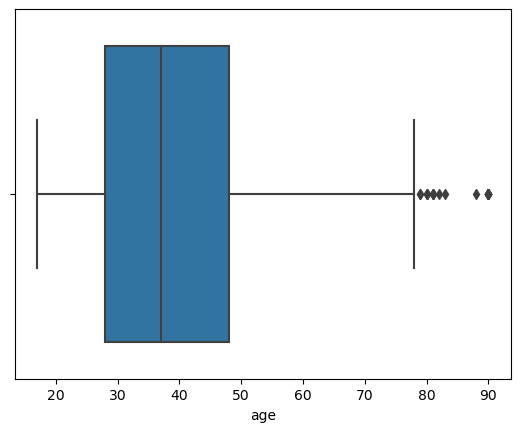

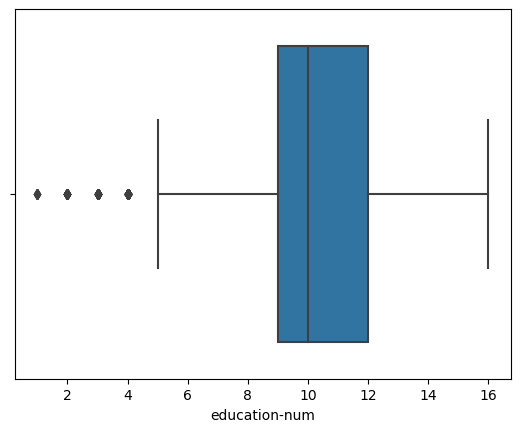

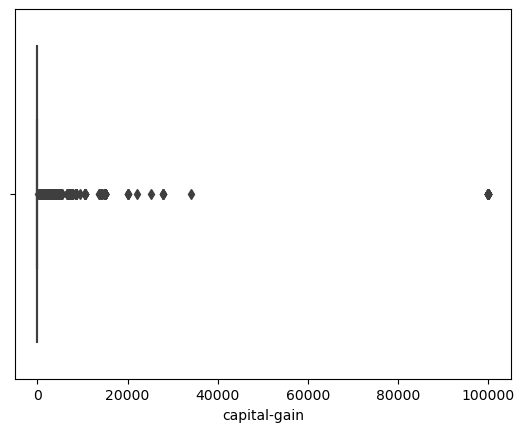

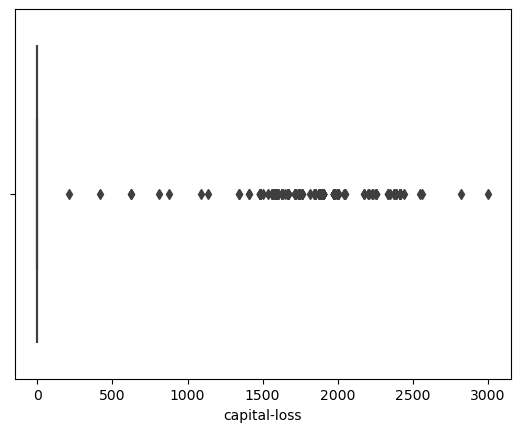

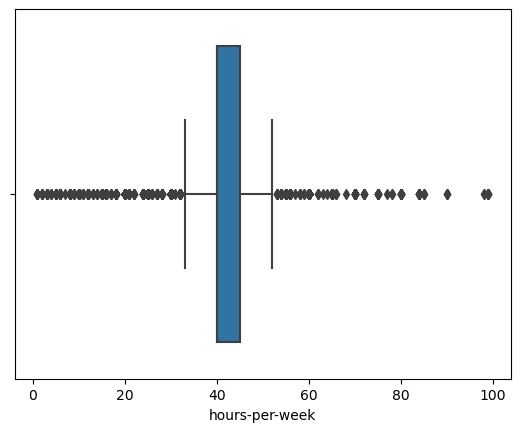

In [84]:
for i in df.select_dtypes(include=[np.number]):
    df[i]
    sns.boxplot(df[i])
    plt.show()

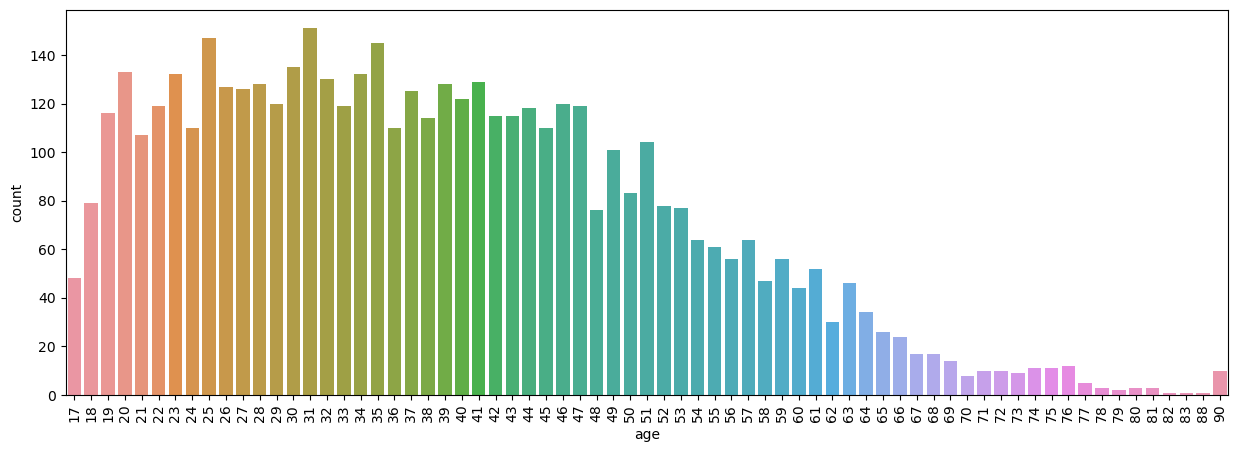

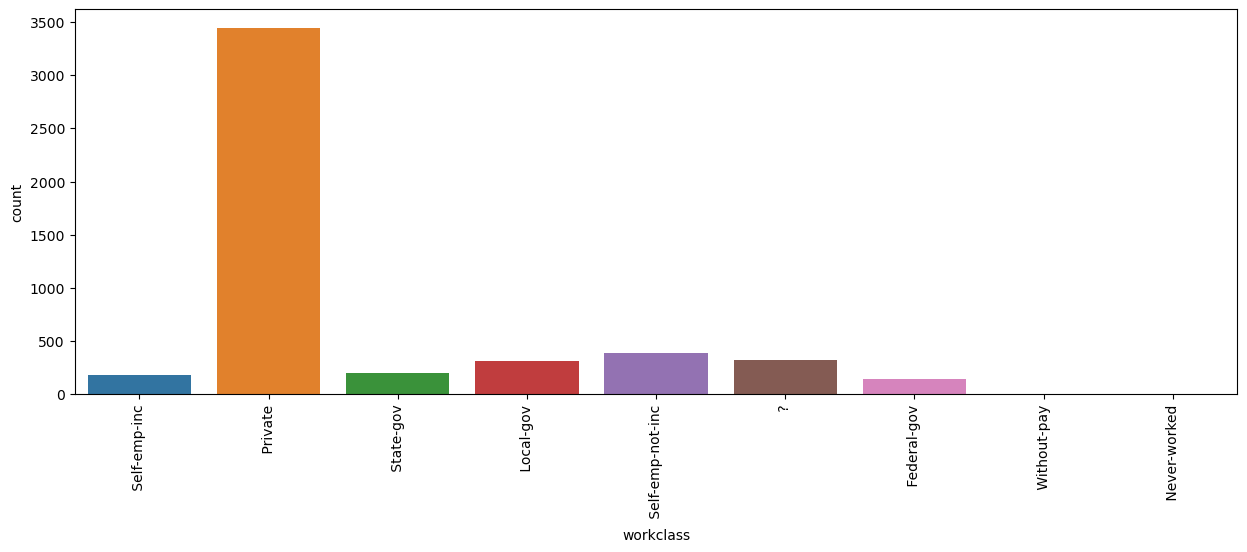

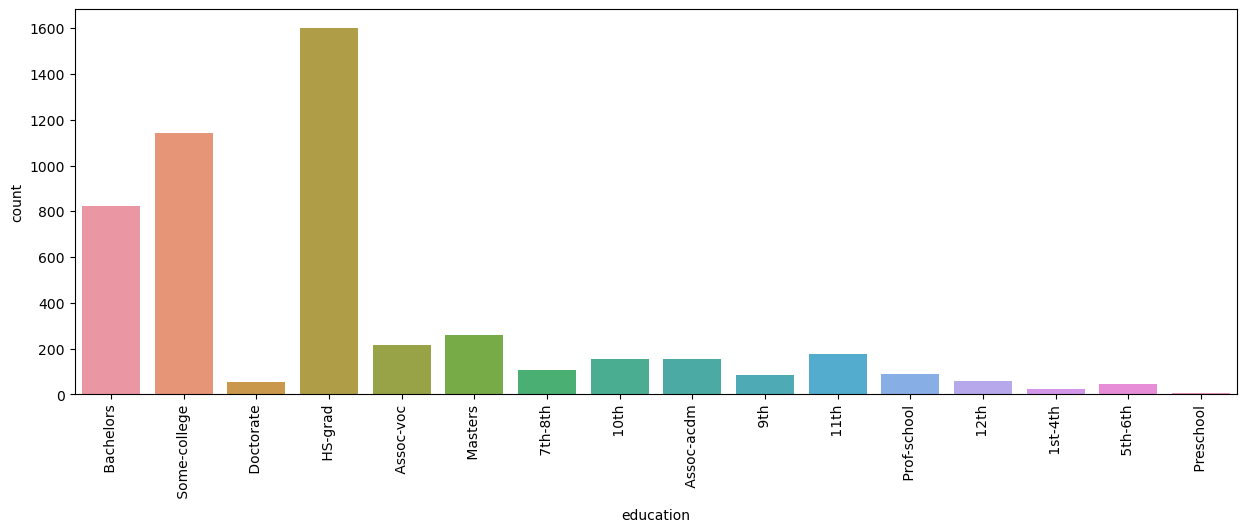

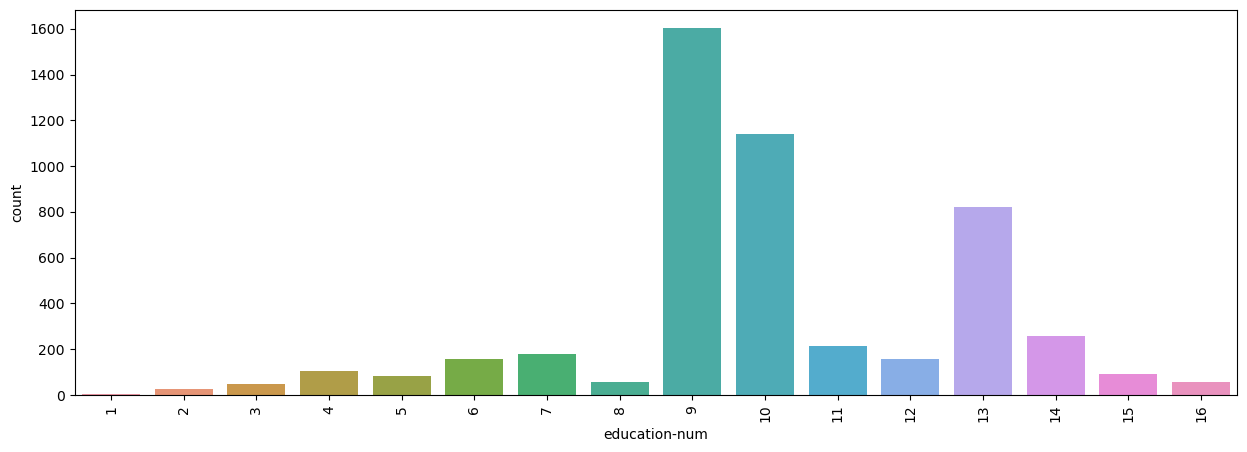

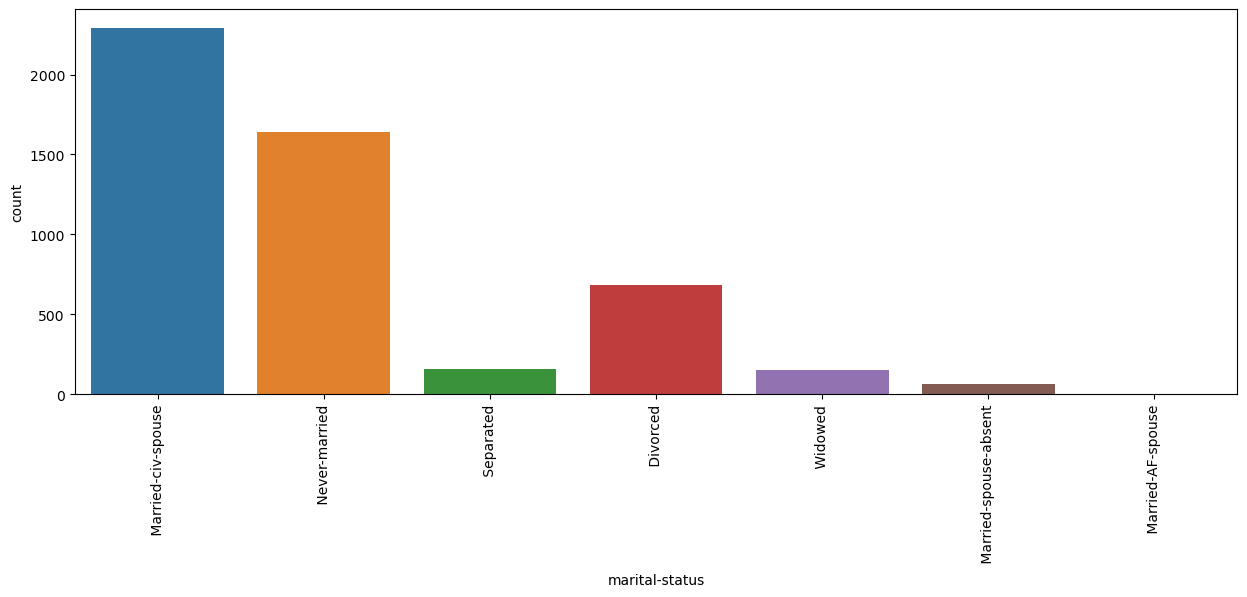

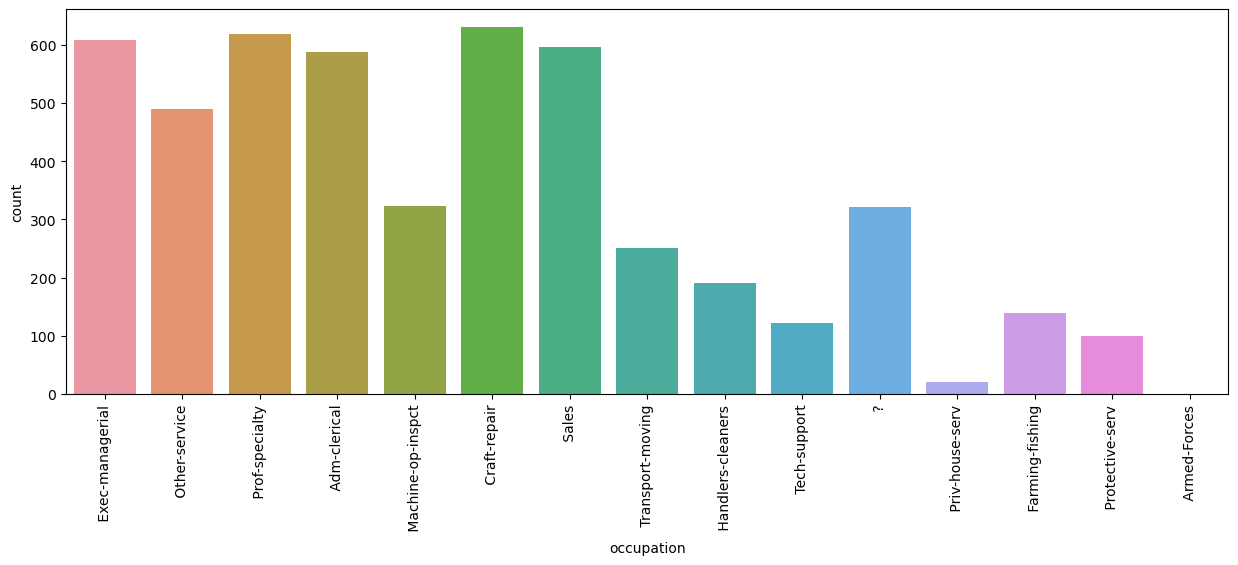

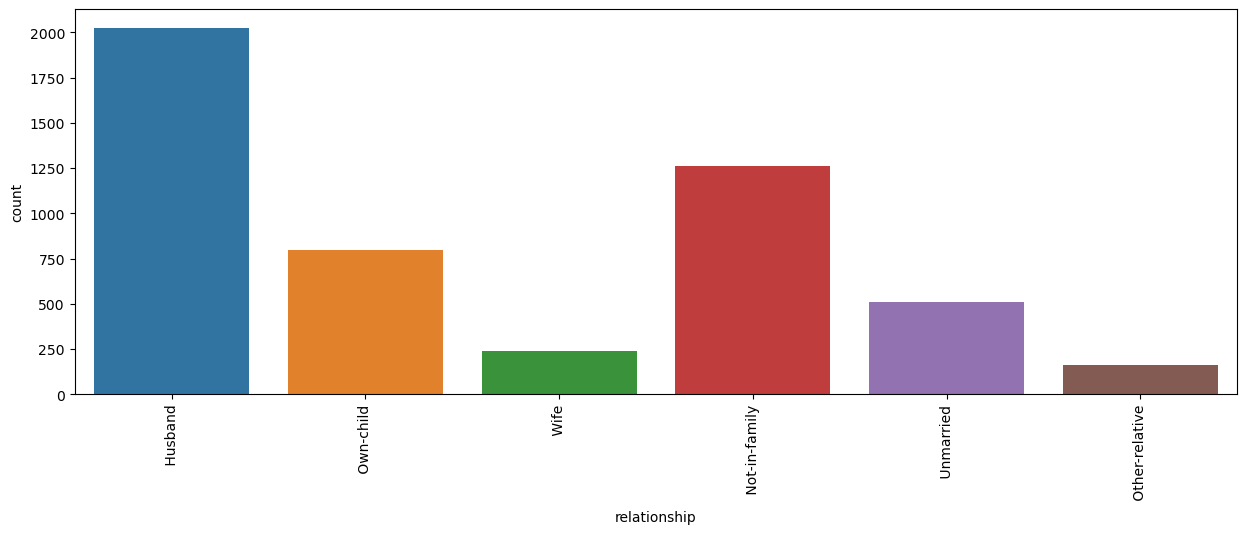

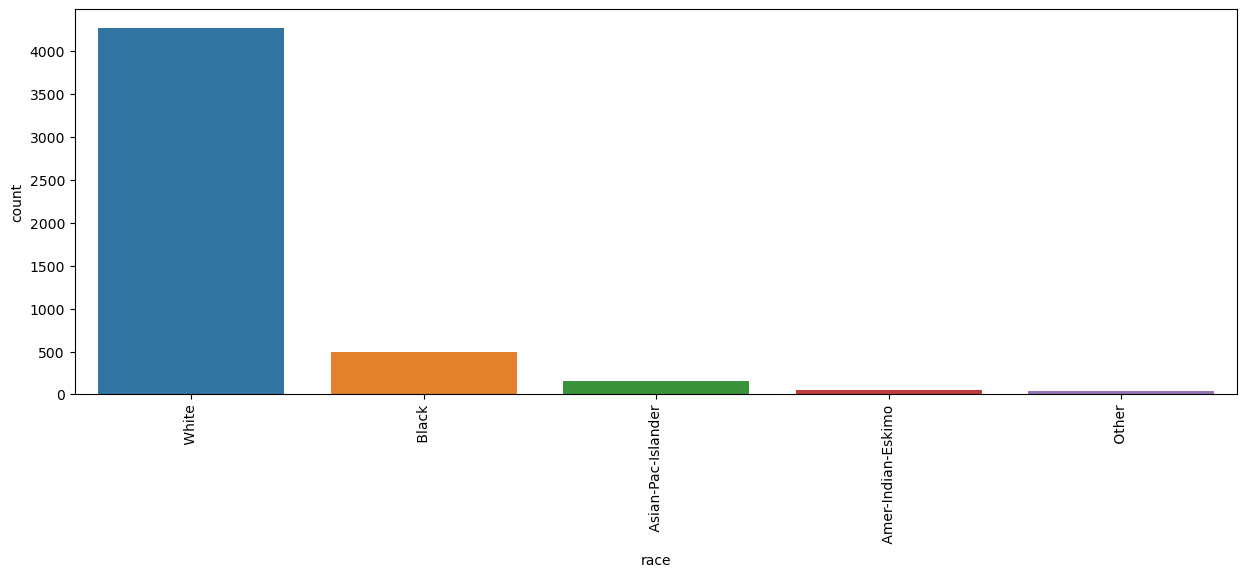

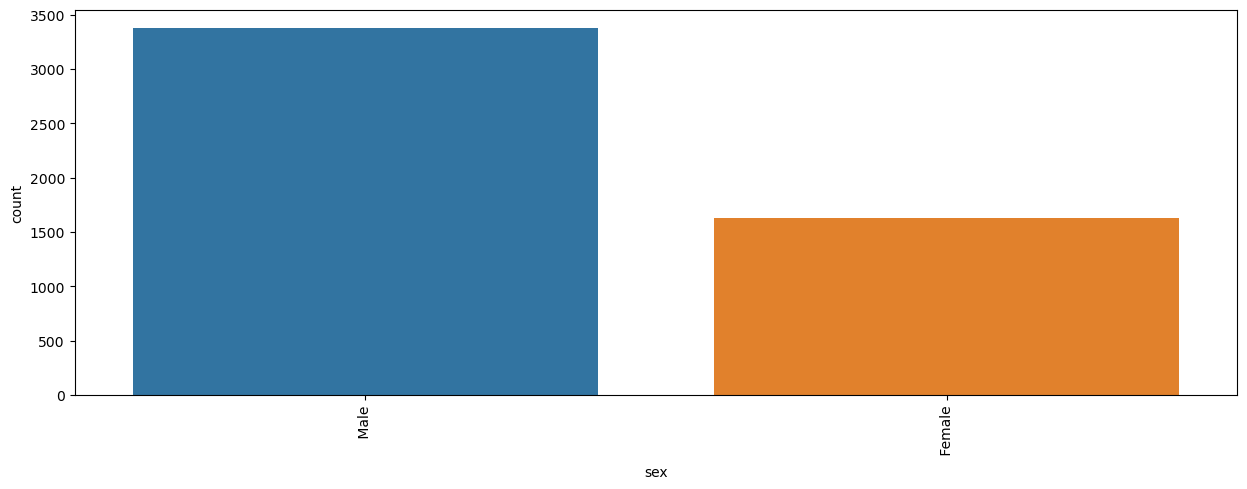

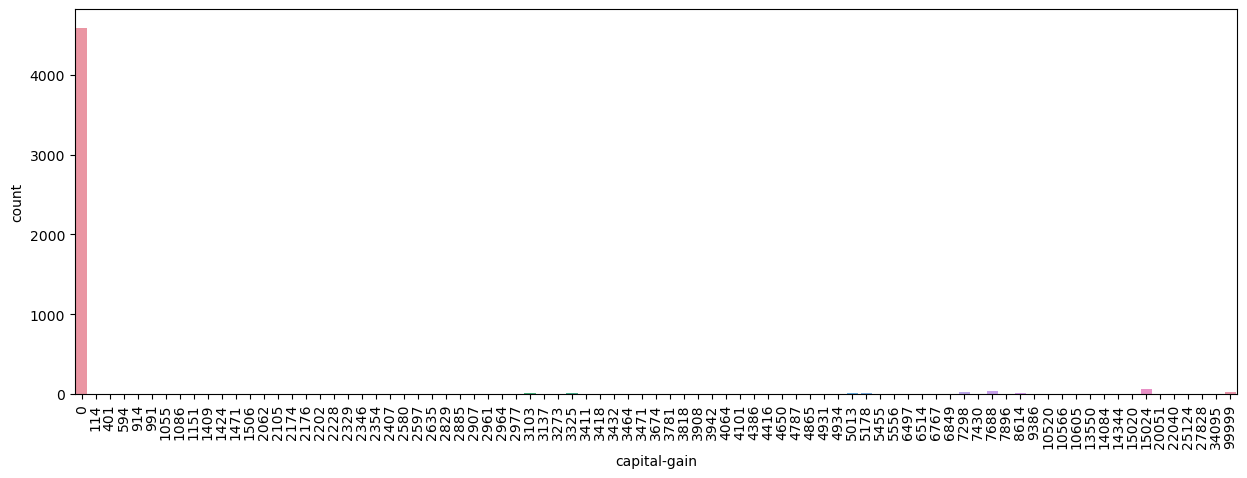

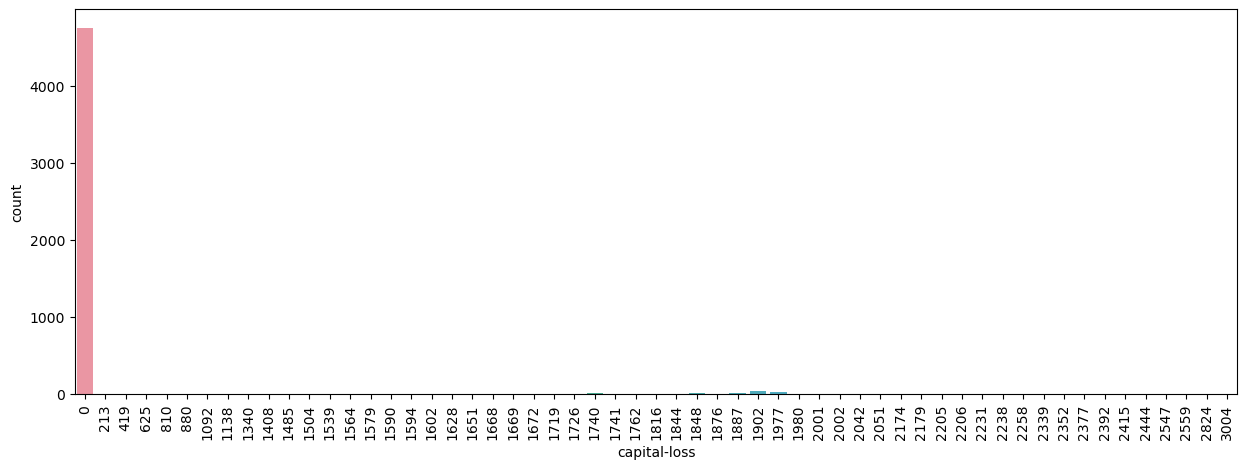

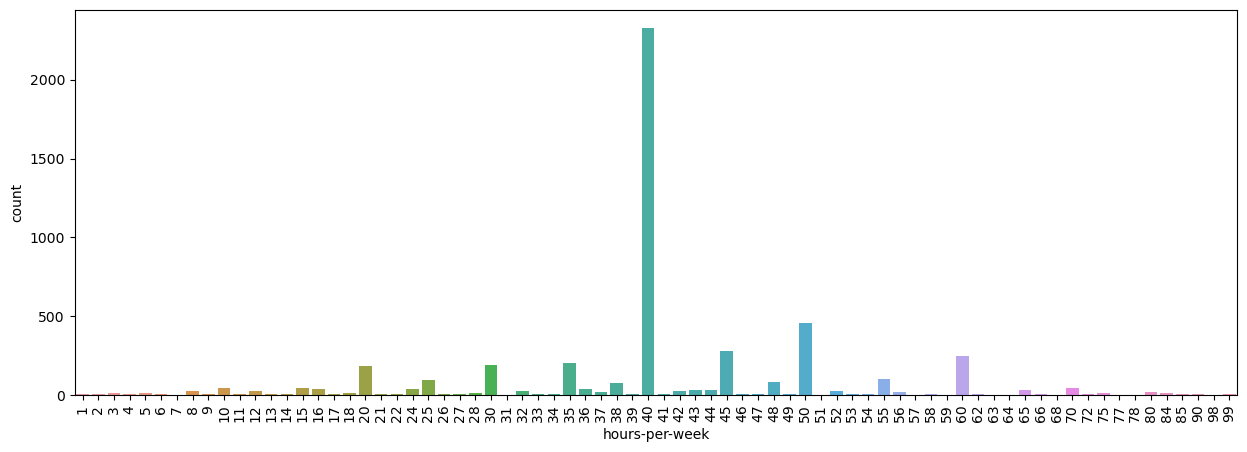

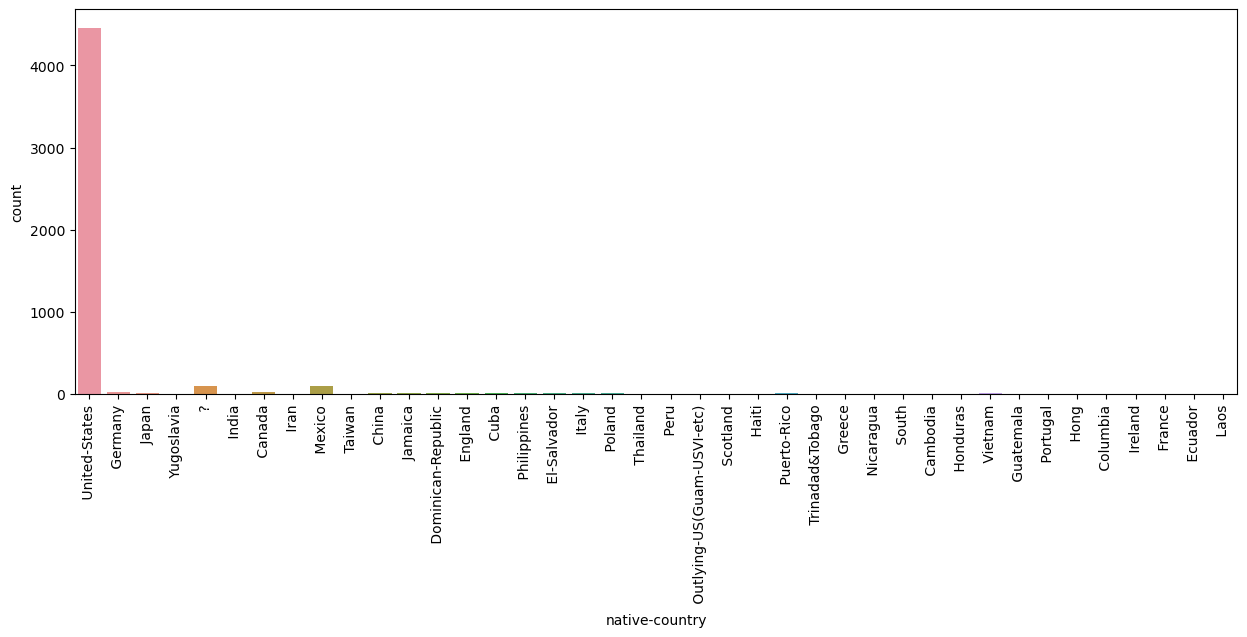

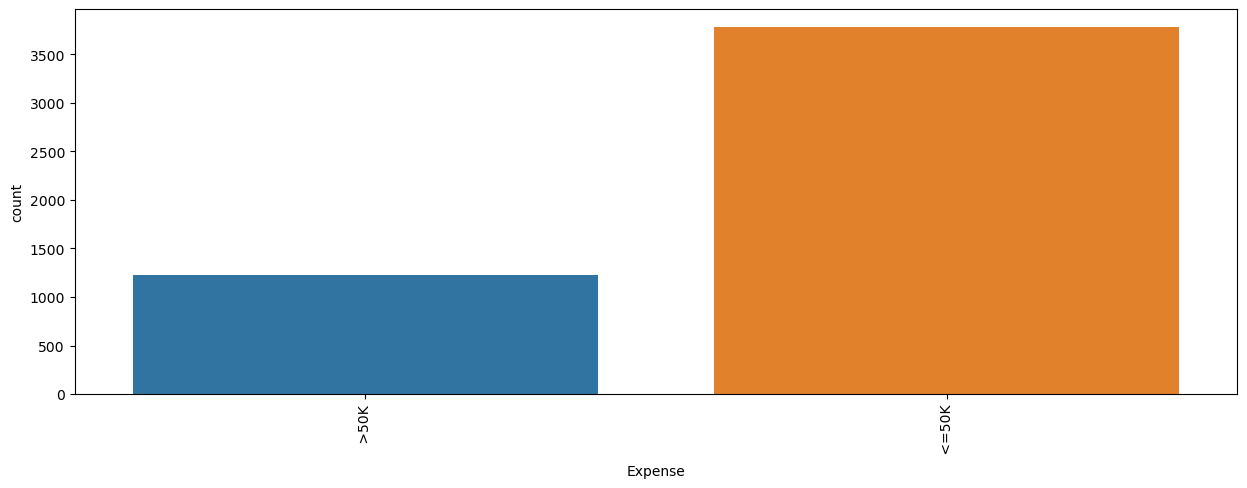

In [10]:
for i in df:
    df[i]
    plt.figure(figsize=(15,5))
    sns.countplot(df[i])
    plt.xticks(rotation=90)
    plt.show()